## **Machine Learning Assignment A2: Fundamental Neural Network Implementation**
### *Studying and Implementing a Multilayer Perceptron from Scratch*

### **Summary**

This project implements and studies a **Multi-Layer Perceptron (MLP)** from scratch


**Project Type:** Option 1- Study a Fundamental Machine Learning Model

**Key Focus Areas:**
- Mathematical Foundations of backpropagation
- Gradient descent optimisation theory
- Loss function design
- Hypothesis space characterisation through architecture choices

**Application Domain:** Fashion-MNIST classification used as a concrete example to demonstrate theoretical concepts

### **1. Task Definition and Learning Framework**

#### **1.1. The Learning Problem**
**Supervised Multi-Class Classification**

Given a training dataset $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^N$ where:
- $\mathbf{x}_i \in \mathcal{X} = \mathbb{R}^{784}$ (input space: flattened 28×28 grayscale images)
- $y_i \in \mathcal{Y} = \{0, 1, 2, ..., 9\}$ (output space: 10 fashion categories)

**Learning Objective:** Find a function $f: \mathcal{X} \rightarrow \mathcal{Y}$ that minimises the expected prediction error on unseen data.

$\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^N$ where:
- $\mathbf{x}_i \in \mathcal{X} = \mathbb{R}^{784}$

#### **1.2. Hypothesis Space Definition**
**The hypothesis space $\mathcal{H}$ consists of all functions that can be represented by a 2-layer feedforward neural network with the specified architecture.**

**Mathematical Formulation:**

$$
\mathcal{H} = \left\{ f_{\mathbf{W}, \mathbf{b}} : \mathbb{R}^{784} \rightarrow \mathbb{R}^{10} \mid f(\mathbf{x}) = \text{Softmax}(\mathbf{W}^{(2)} \cdot \text{ReLU}(\mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)}) + \mathbf{b}^{(2)}) \right\}
$$

Where the parameters are:
- $\mathbf{W}^{(1)} \in \mathbb{R}^{784 \times 128}$: First layer weights (100,352 parameters)
- $\mathbf{b}^{(1)} \in \mathbb{R}^{128}$: First layer biases (128 parameters)
- $\mathbf{W}^{(2)} \in \mathbb{R}^{128 \times 10}$: Second layer weights (1,280 parameters)
- $\mathbf{b}^{(2)} \in \mathbb{R}^{10}$: Second layer biases (10 parameters)

**Total parameter space dimensionality:** 101,770 parameters

**Expressiveness of $\mathcal{H}$:**

According to the Universal Approximation Theorem, this architecture can approximate any continuous function on a compact subset of $\mathbb{R}^{784}$ to arbitrary precision, given sufficient hidden units. However, our choice of 128 hidden units constrains the practical expressiveness.

**Architecture choices that define $\mathcal{H}$:**
1. **Depth:** 2 layers (1 hidden + 1 output) limits hierarchical feature learning
2. **Width:** 128 hidden neurons determines capacity for intermediate representations
3. **Activation:** ReLU introduces piecewise linear decision boundaries
4. **Output:** Softmax constrains outputs to valid probability distributions



### **2. Introduction & Set Up**

#### **2.1. Import Necessary Libaries & Data**

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#### **2.2. Preprocess & Visualise Data**

In [4]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train = X_train.reshape(X_train.shape[0], -1) / 255.0  # Normalize and flatten
X_test = X_test.reshape(X_test.shape[0], -1) / 255.

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")

Training data shape: (60000, 784), Training labels shape: (60000,)


In [5]:
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))

for class_id, count in zip(unique, counts):
    print(f"Class {class_id} ({class_names[class_id]}): {count} samples")

Class distribution in training set: {np.uint8(0): np.int64(6000), np.uint8(1): np.int64(6000), np.uint8(2): np.int64(6000), np.uint8(3): np.int64(6000), np.uint8(4): np.int64(6000), np.uint8(5): np.int64(6000), np.uint8(6): np.int64(6000), np.uint8(7): np.int64(6000), np.uint8(8): np.int64(6000), np.uint8(9): np.int64(6000)}
Class 0 (T-shirt/top): 6000 samples
Class 1 (Trouser): 6000 samples
Class 2 (Pullover): 6000 samples
Class 3 (Dress): 6000 samples
Class 4 (Coat): 6000 samples
Class 5 (Sandal): 6000 samples
Class 6 (Shirt): 6000 samples
Class 7 (Sneaker): 6000 samples
Class 8 (Bag): 6000 samples
Class 9 (Ankle boot): 6000 samples


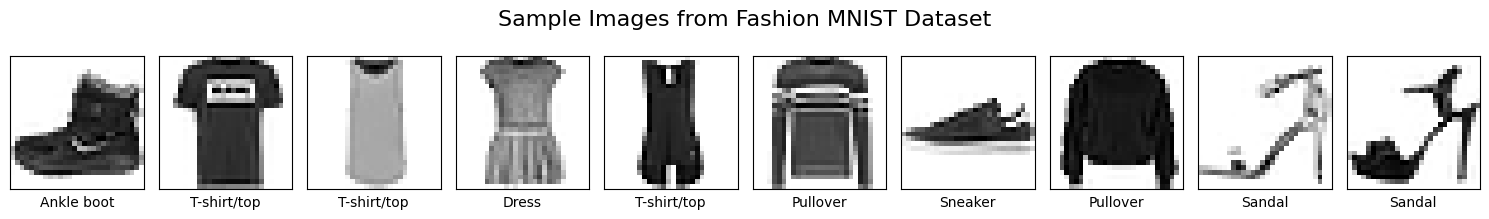

In [6]:
# Visualise samples
plt.figure(figsize=(15,2))
num_images = 10

for i in range (num_images):
    plt.subplot(1, num_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.suptitle('Sample Images from Fashion MNIST Dataset', fontsize=16)
plt.tight_layout()
plt.show()

### **3. Model Components and Implementations**

#### **3.1. Initialise Neural Network**

In [19]:
def initialise(layer_sizes, activation='relu', seed=42):
    np.random.seed(seed)
    num_layers = len(layer_sizes) - 1

    # Initialise weights and biases using Xavier initialisation
    weights = []
    biases = []

    for i in range(num_layers):
        weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))
        bias_vector = np.zeros((1, layer_sizes[i+1]))
        weights.append(weight_matrix)
        biases.append(bias_vector)
    
    print(f"Initialized network with layer sizes: {layer_sizes}")
    print(f"Activation function: {activation}")
    print(f"Number of layers: {num_layers}")
    return weights, biases, layer_sizes, activation

In [20]:
# Network architecture
layer_sizes = [784, 128, 10]  # Input layer, one hidden layers, output layer

weights, biases, _, activation = initialise(layer_sizes, activation='relu', seed=42) 

Initialized network with layer sizes: [784, 128, 10]
Activation function: relu
Number of layers: 2


In [21]:
def count_parameters(weights, biases):
    total_params = 0
    for w, b in zip(weights, biases):
        total_params += w.size + b.size
    return total_params

In [22]:
learning_rate = 0.1
batch_size = 64
epochs = 50

print(f"\n Training parameters:")
print(f"- Learning rate: {learning_rate}")
print(f"- Batch size: {batch_size}")
print(f"- Number of epochs: {epochs}")


 Training parameters:
- Learning rate: 0.1
- Batch size: 64
- Number of epochs: 50


In [23]:
train_loss_history = []
train_acc_history = []
test_acc_history = []

#### **3.2. Activation Functions**

Activation functiosn with their respective derivative

**ReLU (Rectified Linear Unit):**
$$
\text{ReLU}(z) = \max(0, z)
$$

**Derivative:**
$$
\frac{\partial \text{ReLU}(z)}{\partial z} = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{otherwise} \end{cases}
$$

In [24]:
def relu(x):
    return np.maximum(0, x)
def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def apply_activation(x, activation_type):
    if activation_type == 'relu':
        return relu(x)
    elif activation_type == 'tanh':
        return tanh(x)
    elif activation_type == 'sigmoid':
        return sigmoid(x)
    else:
        raise ValueError("Unsupported activation function: {activation_type}")

def apply_activation_derivative(x, activation_type):
    if activation_type == 'relu':
        return relu_derivative(x)
    elif activation_type == 'tanh':
        return tanh_derivative(x)
    elif activation_type == 'sigmoid':
        return sigmoid_derivative(x)
    else:
        raise ValueError("Unsupported activation function: {activation_type}")

**Softmax:**
$$
\text{Softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

For numerical stability, we use:
$$
\text{Softmax}(\mathbf{z})_i = \frac{e^{z_i - \max(\mathbf{z})}}{\sum_{j=1}^{K} e^{z_j - \max(\mathbf{z})}}
$$

In [25]:
def softmax(x):
    shifted_x = x - np.max(x, axis=-1, keepdims=True)  # Prevent overflow
    exp_x = np.exp(shifted_x)

    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

#### **3.3 Forward Propagation**
**Algorithm:**

For each layer $l = 1, 2, ..., L$:
1. Linear transformation: $\mathbf{z}^{(l)} = \mathbf{a}^{(l-1)} \mathbf{W}^{(l)} + \mathbf{b}^{(l)}$
2. Activation: $\mathbf{a}^{(l)} = g^{(l)}(\mathbf{z}^{(l)})$

Where $g^{(l)}$ is ReLU for hidden layers, Softmax for output layer.

**Cache:** Store $\mathbf{z}^{(l)}$ and $\mathbf{a}^{(l)}$ for backpropagation

In [26]:
def forward_pass(X, weights, biases, activation_type, return_cache=False):
    cache = {}
    A = X
    cache['A0'] = X # Store input as activation of layer 0

    num_layers = len(weights)

    for i in range(num_layers):
        # Hidden Layers
        Z = np.dot(A, weights[i]) + biases[i]
        
        if i < num_layers - 1:
            A = apply_activation(Z, activation_type)
        else:
            A = softmax(Z)  # Output layer with softmax
        
        cache[f'Z{i+1}'] = Z
        cache[f'A{i+1}'] = A

    if return_cache:
        return A, cache
    return A

def predict(X, weights, biases, activation_type):
    probabilities = forward_pass(X, weights, biases, activation_type, return_cache=False)
    return np.argmax(probabilities, axis=1)

#### **3.4. Loss Function**

**Categorical Cross-Entropy Loss:**
$$
\mathcal{L}(\mathbf{W}, \mathbf{b}) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

Where:
- $N$ = batch size
- $C$ = number of classes (10)
- $y_{i,c}$ = 1 if sample $i$ belongs to class $c$, 0 otherwise (one-hot encoded)
- $\hat{y}_{i,c}$ = predicted probability for class $c$

**Implementation note:** Added $\epsilon = 10^{-15}$ clipping to prevent $\log(0)$

In [27]:
def cross_entropy_loss(y_true, y_pred):

    '''
    Compute the cross-entropy loss between true labels and predicted probabilities.
    Mathematical Formula:
    L = -1/N * Σ(i=1 to N) Σ(j=1 to C) y_true[i,j] * log(y_pred[i,j])

    Args:
        y_true: A numpy array of shape (m, n) representing one-hot encoded true labels.
        y_pred: A numpy array of shape (m, n) representing predicted probabilities.
    Returns:
        A float representing the average cross-entropy loss over the batch.
    '''
    batch_size = y_pred.shape[0]
    num_classes = y_pred.shape[1]

    if y_true.ndim == 1:
        y_true_onehot = np.zeros((batch_size, num_classes))
        y_true_onehot[np.arange(batch_size), y_true] = 1
    else:
        y_true_onehot = y_true

    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calclulate cross-entropy loss
    sample_losses = -np.sum(y_true_onehot * np.log(y_pred_clipped), axis=1)

    return np.mean(sample_losses), y_true_onehot

#### **3.5 Backpropagation Algorithm**

**Mathematical Derivation:**

**Output Layer ($l=L$):**

For Softmax + Cross-Entropy, the gradient simplifies to:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}} = \mathbf{\hat{y}} - \mathbf{y}
$$

This is a remarkable simplification that combines:
- Softmax derivative: $\frac{\partial \text{Softmax}}{\partial z}$
- Cross-entropy derivative: $\frac{\partial \mathcal{L}}{\partial \hat{y}}$

**Weight and Bias Gradients:**
$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(L)}} &= \frac{1}{m} (\mathbf{a}^{(L-1)})^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}} \\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(L)}} &= \frac{1}{m} \sum_{i=1}^{m} \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}}
\end{align}
$$

**Hidden Layers ($l < L$):**

Chain rule backward propagation:
$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{a}^{(l)}} &= \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(l+1)}} (\mathbf{W}^{(l+1)})^T \\
\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(l)}} &= \frac{\partial \mathcal{L}}{\partial \mathbf{a}^{(l)}} \odot g'(\mathbf{z}^{(l)}) \\
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(l)}} &= \frac{1}{m} (\mathbf{a}^{(l-1)})^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(l)}} \\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(l)}} &= \frac{1}{m} \sum_{i=1}^{m} \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(l)}}
\end{align}
$$

Where $\odot$ is element-wise multiplication and $g'$ is the activation derivative.

**Gradient Descent Update:**
$$
\begin{align}
\mathbf{W}^{(l)} &:= \mathbf{W}^{(l)} - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(l)}} \\
\mathbf{b}^{(l)} &:= \mathbf{b}^{(l)} - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(l)}}
\end{align}
$$

Where $\alpha$ is the learning rate.

In [31]:
def backward_pass(cache, y_true_onehot, weights, activation_type):
    """
    Backward propagation through the network
    
    Mathematical Formulation:
    
    For output layer (L):
    dZ[L] = A[L] - y_true  (gradient after softmax + cross-entropy)
    dW[L] = (1/m) * A[L-1].T @ dZ[L]
    db[L] = (1/m) * sum(dZ[L], axis=0)
    
    For hidden layers (l = L-1, L-2, ..., 1):
    dA[l] = dZ[l+1] @ W[l+1].T
    dZ[l] = dA[l] * activation_derivative(Z[l])
    dW[l] = (1/m) * A[l-1].T @ dZ[l]
    db[l] = (1/m) * sum(dZ[l], axis=0)
    
    Args:
        cache: Dictionary containing forward pass intermediate values
        y_true_onehot: One-hot encoded true labels (batch_size, num_classes)
        weights: List of weight matrices
        activation_type: Type of activation function used in hidden layers
    
    Returns:
        gradients: Dictionary containing gradients for weights and biases
    """
    
    num_layers = len(weights)
    batch_size = y_true_onehot.shape[0]
    
    # Initialize gradients lists with correct size
    dW_gradients = [None] * num_layers
    db_gradients = [None] * num_layers
    
    # print(f"Starting backpropagation...")
    # print(f"Batch size: {batch_size}, Number of layers: {num_layers}")
    
    # OUTPUT LAYER GRADIENTS
    # For softmax + cross-entropy, the gradient simplifies to: dZ = A - y_true
    A_output = cache[f'A{num_layers}']  # Final predictions (after softmax)
    dZ = A_output - y_true_onehot  # Shape: (batch_size, num_classes)
    
    # print(f"Output layer gradient dZ shape: {dZ.shape}")
    
    # Gradients for output layer weights and biases (last layer index)
    A_prev = cache[f'A{num_layers-1}']  # Activations from previous layer
    dW = (1/batch_size) * A_prev.T @ dZ  # Shape: (prev_layer_size, num_classes)
    db = (1/batch_size) * np.sum(dZ, axis=0, keepdims=True)  # Shape: (1, num_classes)
    
    # Store output layer gradients at correct index
    dW_gradients[num_layers-1] = dW
    db_gradients[num_layers-1] = db
    
    # print(f"Output layer (index {num_layers-1}): dW shape = {dW.shape}, db shape = {db.shape}")
    
    # HIDDEN LAYER GRADIENTS
    # Work backwards from layer (L-1) to layer 0
    for layer_idx in range(num_layers - 2, -1, -1): 
        # Propagate error backwards: dA = dZ_next @ W_next.T
        next_layer_idx = layer_idx + 1
        dA = dZ @ weights[next_layer_idx].T  # Shape: (batch_size, current_layer_size)
        
        # Get pre-activation values and compute activation derivative
        Z_current = cache[f'Z{layer_idx+1}']  # Pre-activation values (cache uses 1-based indexing)
        activation_derivative = apply_activation_derivative(Z_current, activation_type)
        
        # Apply chain rule: dZ = dA * activation_derivative
        dZ = dA * activation_derivative  # Element-wise multiplication
        
        # Get activations from previous layer
        A_prev = cache[f'A{layer_idx}']  # Previous layer activations
        
        # Calculate weight and bias gradients
        dW = (1/batch_size) * A_prev.T @ dZ
        db = (1/batch_size) * np.sum(dZ, axis=0, keepdims=True)
        
        # Store gradients at correct index
        dW_gradients[layer_idx] = dW
        db_gradients[layer_idx] = db
        
        # print(f"Layer {layer_idx}: dZ shape = {dZ.shape}, dW shape = {dW.shape}, db shape = {db.shape}")
    
    gradients = {'dW': dW_gradients, 'db': db_gradients}
    
    # print("Backpropagation complete!")
    return gradients

In [32]:
def update_weights(weights, biases, gradients, learning_rate):
    """
    Update weights and biases using gradients
    
    Mathematical Update Rule:
    W_new = W_old - learning_rate * dW
    b_new = b_old - learning_rate * db
    
    Args:
        weights: List of current weight matrices
        biases: List of current bias vectors
        gradients: Dictionary containing gradients
        learning_rate: Step size for gradient descent
    
    Returns:
        Updated weights and biases (in-place modification)
    """
    num_layers = len(weights)
    for i in range(num_layers):
        weights[i] -= learning_rate * gradients['dW'][i]
        biases[i] -= learning_rate * gradients['db'][i].reshape(1, -1)
    return weights, biases

In [33]:
def train_one_step(X, y_true, weights, biases, activation_type, learning_rate=0.01):
    """
    Complete training step: forward pass + backward pass + weight update
    
    Args:
        X: Input data (batch_size, input_features)
        y_true: True labels (batch_size,)
        weights: List of weight matrices
        biases: List of bias vectors
        activation_type: Activation function for hidden layers
        learning_rate: Learning rate for gradient descent
    
    Returns:
        loss: Current loss value
        accuracy: Current accuracy percentage
        weights: Updated weights
        biases: Updated biases
    """
    # Forward pass
    predictions, cache = forward_pass(X, weights, biases, activation_type, return_cache=True)
    
    # Calculate loss
    loss, y_true_onehot = cross_entropy_loss(y_true, predictions)
    
    # Calculate accuracy
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_true) * 100
    
    # Backward pass
    gradients = backward_pass(cache, y_true_onehot, weights, activation_type)
    
    # Update weights
    weights, biases = update_weights(weights, biases, gradients, learning_rate)
    
    return loss, accuracy, weights, biases

### **4. Model Training and Evaluation**

#### **4.1. Training Configuration**

**Hyperparameters:**
- Learning rate: $\alpha = 0.1$
- Batch size: 64
- Epochs: 100
- Optimizer: Stocastic Gradient Descent (SGD) with mini-batches

**Training Strategy:**
- Mini-bacth training: Process 64 samples at a time
- Data shuffling: Randomise order each epoch to prevent overfitting
- Monitoring: Track training loss, training accuracy, test accuracy per epoch

In [34]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Track metrics for the epoch
    epoch_losses = []
    epoch_accuracies = []

    #train in mini-batches
    n_batches = len(X_train) // batch_size

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]

        loss, accuracy, weights, biases = train_one_step(
            X_batch, y_batch, weights, biases, activation, learning_rate
        )
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

        # Print batch metrics every 500 batches
        # if batch_idx % 500 == 0:
            # print(f" Batch {batch_idx+1}/{n_batches} - Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    avg_train_loss = np.mean(epoch_losses)
    avg_train_acc = np.mean(epoch_accuracies)

    test_subset_size = 1000
    test_indices = np.random.choice(X_test.shape[0], test_subset_size, replace=False)
    X_test_subset = X_test[test_indices]
    y_test_subset = y_test[test_indices]

    test_predictions = forward_pass(X_test_subset, weights, biases, activation, return_cache=False)
    test_predicted_classes = np.argmax(test_predictions, axis=1)
    test_accuracy = np.mean(test_predicted_classes == y_test_subset) * 100

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    test_acc_history.append(test_accuracy)

    print(f" Epoch {epoch+1} complete - Avg Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.2f}%, Test Acc: {test_accuracy:.2f}%\n")
    print()
print("Training completed")

Epoch 1/50
 Epoch 1 complete - Avg Loss: 0.5864, Avg Train Acc: 79.50%, Test Acc: 80.90%


Epoch 2/50
 Epoch 2 complete - Avg Loss: 0.4259, Avg Train Acc: 84.77%, Test Acc: 83.80%


Epoch 3/50
 Epoch 3 complete - Avg Loss: 0.3860, Avg Train Acc: 86.29%, Test Acc: 86.40%


Epoch 4/50
 Epoch 4 complete - Avg Loss: 0.3608, Avg Train Acc: 87.07%, Test Acc: 85.80%


Epoch 5/50
 Epoch 5 complete - Avg Loss: 0.3415, Avg Train Acc: 87.62%, Test Acc: 86.30%


Epoch 6/50
 Epoch 6 complete - Avg Loss: 0.3270, Avg Train Acc: 88.09%, Test Acc: 87.90%


Epoch 7/50
 Epoch 7 complete - Avg Loss: 0.3141, Avg Train Acc: 88.64%, Test Acc: 86.20%


Epoch 8/50
 Epoch 8 complete - Avg Loss: 0.3026, Avg Train Acc: 89.06%, Test Acc: 88.90%


Epoch 9/50
 Epoch 9 complete - Avg Loss: 0.2940, Avg Train Acc: 89.38%, Test Acc: 87.20%


Epoch 10/50
 Epoch 10 complete - Avg Loss: 0.2854, Avg Train Acc: 89.51%, Test Acc: 87.40%


Epoch 11/50
 Epoch 11 complete - Avg Loss: 0.2795, Avg Train Acc: 89.83%, Test Acc: 87.7

#### **4.1.1 Comparitive experiment of RELU and Tanh**

Initialized network with layer sizes: [784, 128, 10]
Activation function: relu
Number of layers: 2
RELU Epoch 1/10 - Train Acc: 79.50%, Test Acc: 82.30%
RELU Epoch 2/10 - Train Acc: 84.92%, Test Acc: 86.15%
RELU Epoch 3/10 - Train Acc: 86.18%, Test Acc: 86.15%
RELU Epoch 4/10 - Train Acc: 87.16%, Test Acc: 85.10%
RELU Epoch 5/10 - Train Acc: 87.68%, Test Acc: 87.35%
RELU Epoch 6/10 - Train Acc: 88.28%, Test Acc: 87.30%
RELU Epoch 7/10 - Train Acc: 88.59%, Test Acc: 87.85%
RELU Epoch 8/10 - Train Acc: 89.03%, Test Acc: 87.95%
RELU Epoch 9/10 - Train Acc: 89.30%, Test Acc: 88.00%
RELU Epoch 10/10 - Train Acc: 89.55%, Test Acc: 88.05%
Initialized network with layer sizes: [784, 128, 10]
Activation function: tanh
Number of layers: 2
TANH Epoch 1/10 - Train Acc: 80.16%, Test Acc: 82.95%
TANH Epoch 2/10 - Train Acc: 84.63%, Test Acc: 85.65%
TANH Epoch 3/10 - Train Acc: 85.84%, Test Acc: 86.40%
TANH Epoch 4/10 - Train Acc: 86.78%, Test Acc: 85.80%
TANH Epoch 5/10 - Train Acc: 87.22%, Test Acc

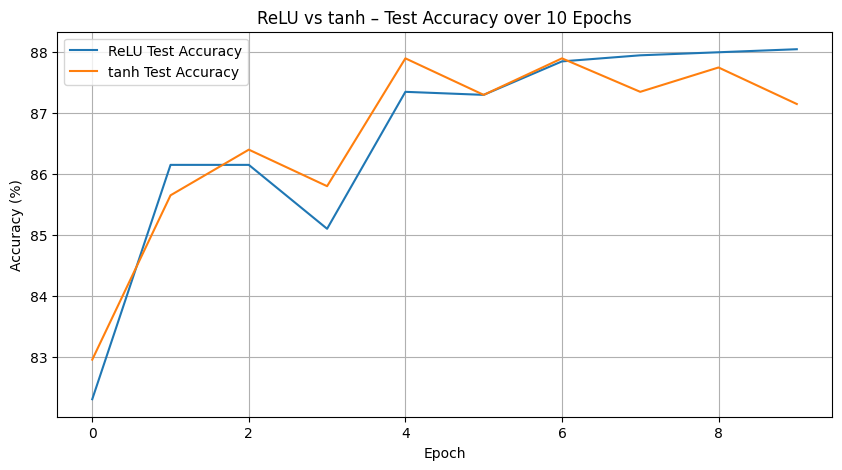

In [35]:
# Compare ReLU vs tanh
def train_model(X_train, y_train, X_test, y_test, activation_type, epochs=10, lr=0.1):
    layer_sizes = [784, 128, 10]
    weights, biases, _, _ = initialise(layer_sizes, activation=activation_type)
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        n_batches = len(X_train) // batch_size
        epoch_acc = []

        for batch_idx in range(n_batches):
            start, end = batch_idx * batch_size, (batch_idx + 1) * batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            _, acc, weights, biases = train_one_step(X_batch, y_batch, weights, biases, activation_type, learning_rate=lr)
            epoch_acc.append(acc)

        # Evaluate test accuracy each epoch
        preds = predict(X_test, weights, biases, activation_type)
        test_accuracy = np.mean(preds == y_test) * 100

        train_acc.append(np.mean(epoch_acc))
        test_acc.append(test_accuracy)

        print(f"{activation_type.upper()} Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.2f}%, Test Acc: {test_acc[-1]:.2f}%")

    return train_acc, test_acc

relu_train_acc, relu_test_acc = train_model(X_train, y_train, X_test[:2000], y_test[:2000], 'relu', epochs=10)
tanh_train_acc, tanh_test_acc = train_model(X_train, y_train, X_test[:2000], y_test[:2000], 'tanh', epochs=10)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(relu_test_acc, label='ReLU Test Accuracy')
plt.plot(tanh_test_acc, label='tanh Test Accuracy')
plt.title('ReLU vs tanh – Test Accuracy over 10 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


#### **4.2 Evaluate Results**

In [ ]:
#Accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test_predictions_full = forward_pass(X_test, weights, biases, activation, return_cache=False)
predicted_classes = np.argmax(test_predictions_full, axis=1)

accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')
print(f"  Accuracy:  {accuracy*100:.2f}%")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

  Accuracy:  88.94%
  Precision: 0.8894
  Recall:    0.8894
  F1-Score:  0.8891


##### **4.2.1 Errors and Accuracy Plots**

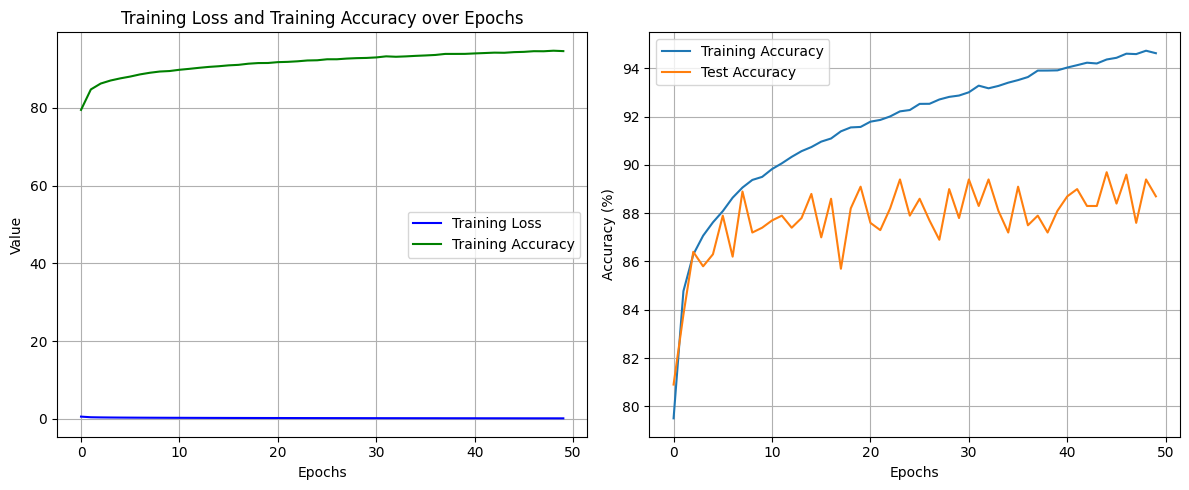

In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(train_acc_history, label='Training Accuracy', color='green')
plt.title('Training Loss and Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### **4.2.2. Visualising Misclassification Examples**

Total misclassified: 1106 out of 10000
Test accuracy: 88.94%


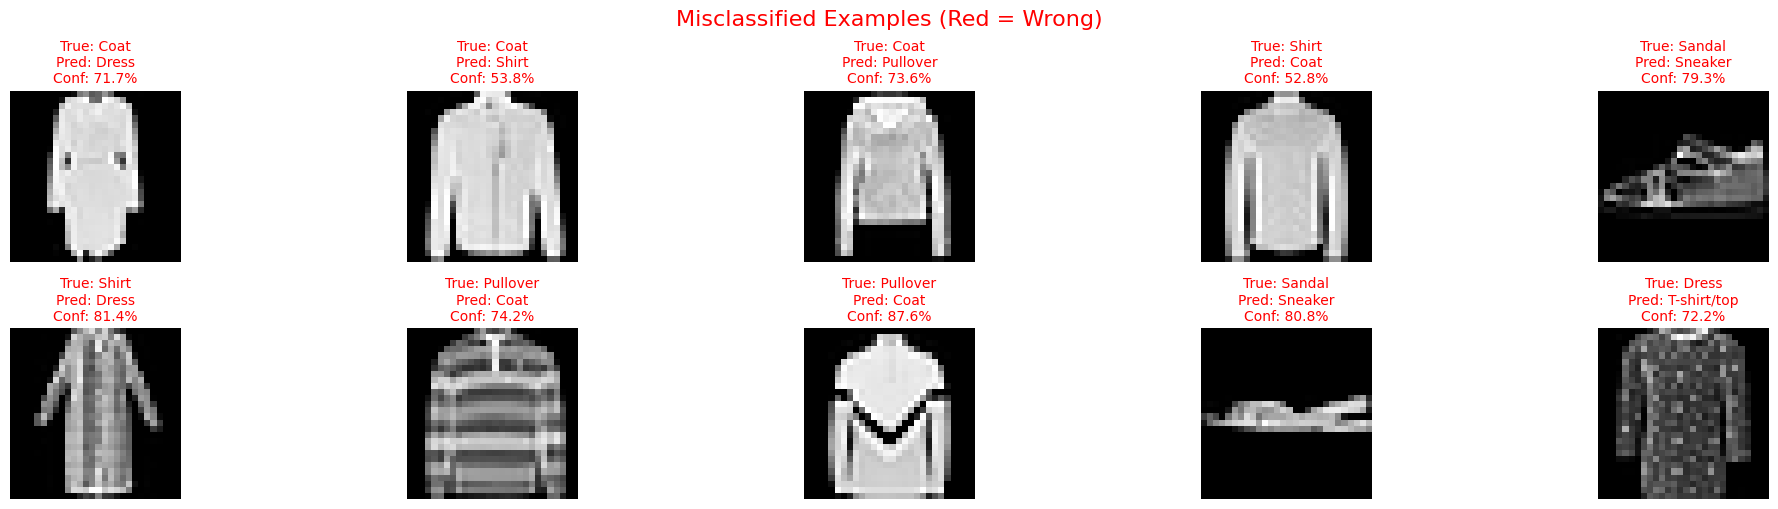


Most common misclassifications:
  T-shirt/top  → Shirt       : 108 times
  Shirt        → T-shirt/top : 105 times
  Shirt        → Pullover    : 94 times
  Pullover     → Coat        : 93 times
  Coat         → Pullover    : 74 times
  Shirt        → Coat        : 74 times
  Pullover     → Shirt       : 53 times
  Ankle boot   → Sneaker     : 53 times
  Coat         → Shirt       : 48 times
  Coat         → Dress       : 44 times


In [37]:
test_predictions_all = []
test_batch_size = 1000

for i in range(0, len(X_test), test_batch_size):
    batch_end = min(i + test_batch_size, len(X_test))
    batch_predictions = forward_pass(X_test[i:batch_end], weights, biases, activation)
    test_predictions_all.append(batch_predictions)

# Combine all predictions
all_test_predictions = np.vstack(test_predictions_all)
predicted_classes = np.argmax(all_test_predictions, axis=1)

# Find misclassified examples
misclassified_indices = np.where(predicted_classes != y_test)[0]
print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test)}")
print(f"Test accuracy: {100 * (1 - len(misclassified_indices)/len(y_test)):.2f}%")

# Visualise misclassified examples
num_examples = 10
random_wrong = np.random.choice(misclassified_indices, min(num_examples, len(misclassified_indices)), replace=False)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(random_wrong):
    plt.subplot(4, 5, i + 1)
    
    # Get the image (reshape back to 28x28)
    img = X_test[idx].reshape(28, 28)
    
    # Get predictions
    true_class = y_test[idx]
    pred_class = predicted_classes[idx]
    confidence = all_test_predictions[idx][pred_class] * 100
    
    # Display image
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # Title with true vs predicted
    plt.title(f'True: {class_names[true_class]}\n'
              f'Pred: {class_names[pred_class]}\n'
              f'Conf: {confidence:.1f}%',
              fontsize=10, color='red')

plt.suptitle('Misclassified Examples (Red = Wrong)', fontsize=16, color='red')
plt.tight_layout()
plt.show()

# Show confusion patterns - which classes get confused most
print("\nMost common misclassifications:")
confusion_pairs = []
for idx in misclassified_indices:
    true_class = y_test[idx]
    pred_class = predicted_classes[idx]
    confusion_pairs.append((true_class, pred_class))

from collections import Counter
top_confusions = Counter(confusion_pairs).most_common(10)

for (true_cls, pred_cls), count in top_confusions:
    print(f"  {class_names[true_cls]:12s} → {class_names[pred_cls]:12s}: {count} times")

##### **4.2.3. Confusion Matrix**

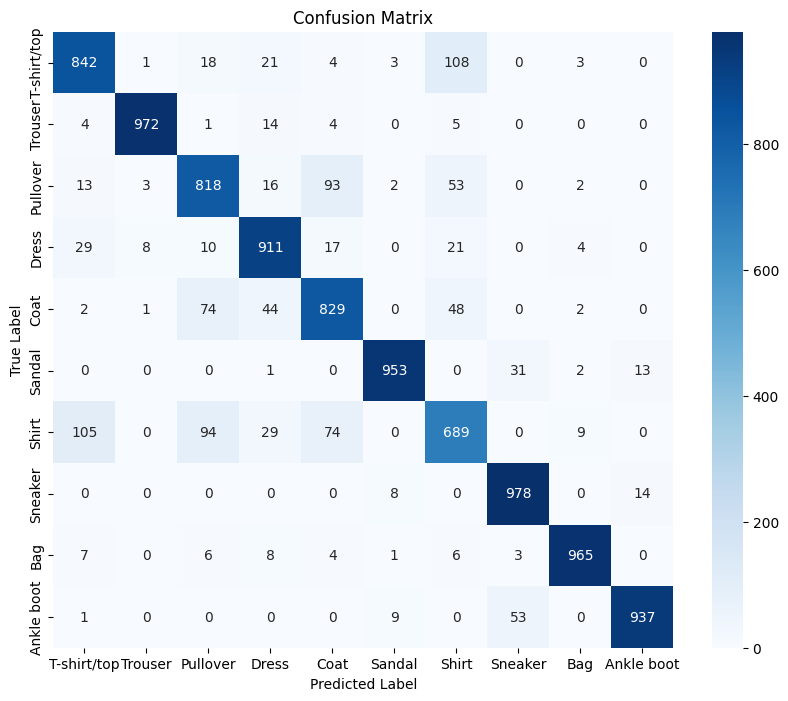

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


##### **4.2.4. ROC Curve & ROC-AUC**

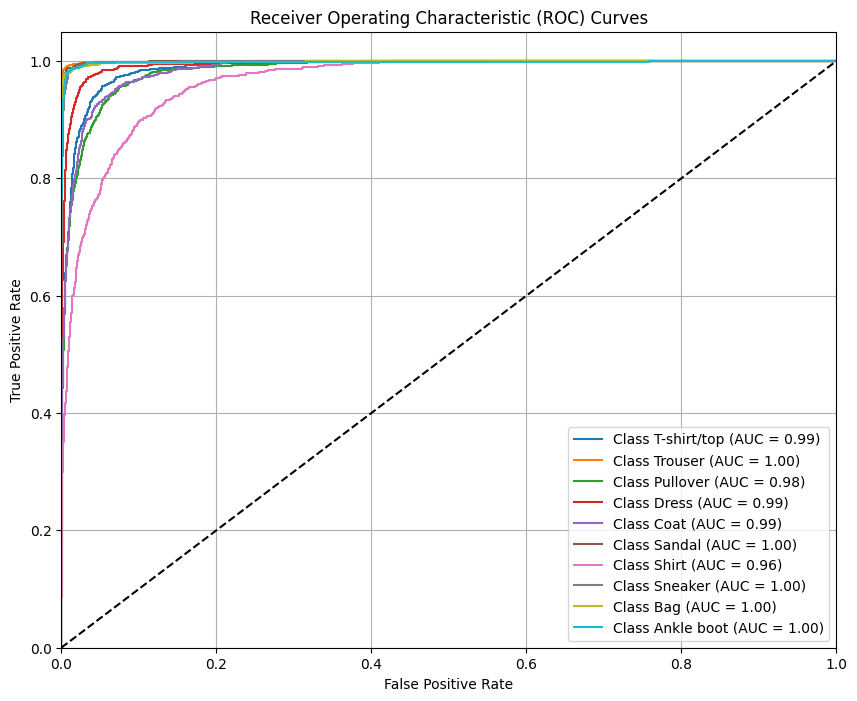

In [41]:
# ROC Curve & ROC-AUC
# ROC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=np.arange(10))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()